In [1]:
import gc
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import save_results
from models import least_squares, gradient_descent, ridge_regression
from preprocessing import (features_expansion, features_selection,
                                    get_initial_df, preparation, splitting, build_poly)
from visualization import snr_plot, y_compare, ridge_regression_lambdas_visualization
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

In [2]:
OUTPUT_FILE = "results.csv"

In [3]:
df_spectra, df_measures, df_tts = get_initial_df('data')
meta_cols = ['SiteCode', 'Date', 'flag',
             'Latitude', 'Longitude']
unc_col = 'DUSTf:Unc'

y_col = 'DUSTf:Value'

In [4]:
merged = preparation(df_spectra, df_measures, meta_cols, unc_col, y_col)
%xdel df_spectra
%xdel df_measures
print("Shape: merged: {}".format(merged.shape))

Shape: merged: (18001, 2791)


In [5]:
tx_train, y_train, _, tx_test, y_test, unc_test = splitting(merged,df_tts,meta_cols,unc_col,y_col)
print("Shapes:\n\ttx_train: {}\n\ty_train: {}\n\ttx_test: {}\n\ty_test: {}".format(tx_train.shape, y_train.shape, tx_test.shape, y_test.shape))
%xdel merged
%xdel df_tts

Shapes:
	tx_train: (13357, 2784)
	y_train: (13357,)
	tx_test: (4644, 2784)
	y_test: (4644,)


In [6]:
gd_initial_weights = np.random.rand(tx_train.shape[1])
print(gd_initial_weights.shape)

(2784,)


In [7]:
with open(OUTPUT_FILE, "w") as f:
    writer = csv.writer(f)
    writer.writerow(["method", 'w', 'loss'])

# No feature preprocessing at all

## BASELINE

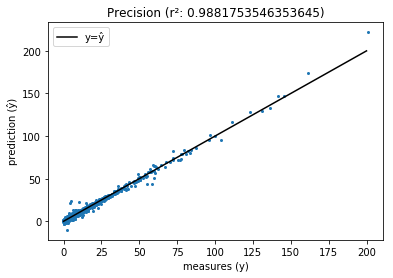

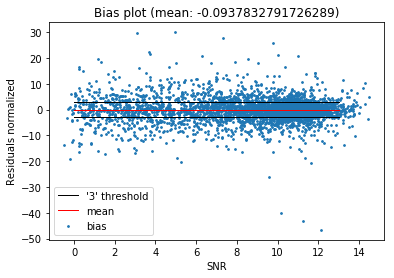

Loss is 0.6638077119752045


In [8]:
loss, weights_baseline = least_squares(tx_train, y_train, tx_test, y_test)
save_results(OUTPUT_FILE, "simple least squares", weights_baseline, loss)
y_compare(tx_test, y_test, weights_baseline, "ls_y-compare_simple.png")
snr_plot(tx_test, y_test, weights_baseline, unc_test, "ls_snr_simple.png")
print("Loss is {}".format(loss))

## Gradient descent

Iteration 0, loss is 1503.2071134845903
Iteration 100, loss is 85.27820689024873
Iteration 200, loss is 50.53176017454233
Iteration 264, loss was 43.277167972301875, now is 43.268528542942605, diff = 0.008639429359270423


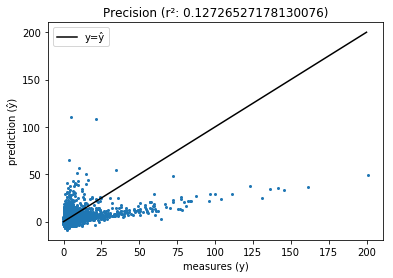

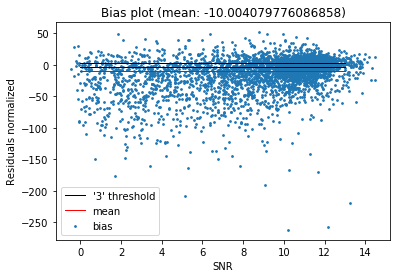

Loss is: 43.268528542942605


In [14]:
loss, weights_sgd = gradient_descent(tx_train, y_train, gd_initial_weights, 1000, 0.005)
save_results(OUTPUT_FILE, "simple stochastic gradient descent", weights_baseline, loss)
y_compare(tx_test, y_test, weights_sgd, "GD_y-compare_simple.png")
snr_plot(tx_test, y_test, weights_sgd, unc_test, "GD_snr_simple.png")
print("Loss is: {}".format(loss))

### Visualization of the difference of regression weights

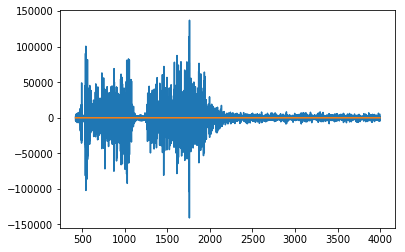

In [15]:
plt.plot(tx_train.columns, weights_baseline)
plt.plot(tx_train.columns, weights_sgd)
# plt.yscale('log')
plt.show()

## Least-Squares with Cross-validation

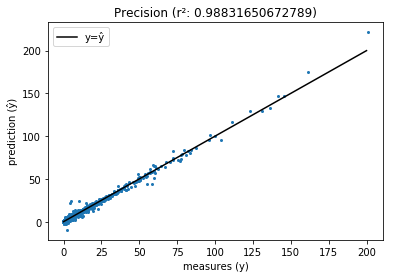

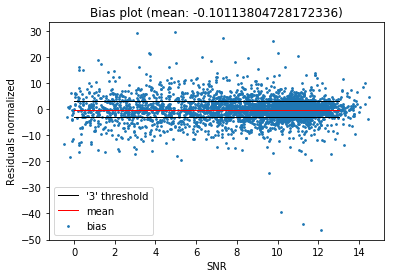

Loss is 1.050775433139568


In [16]:
kf = KFold(n_splits=10, shuffle=True)
losses, ws = [],[]
for ind_tr, ind_te in kf.split(tx_train):
    loss, w = least_squares(tx_train.iloc[ind_tr].values, 
                            y_train.iloc[ind_tr].values,
                            tx_train.iloc[ind_te].values,
                            y_train.iloc[ind_te].values)
    losses.append(loss)
    ws.append(w)

weights_cross = np.mean(np.array(ws), axis=0)
loss_cross = np.mean(losses)
y_compare(tx_test, y_test, weights_cross, "ls-cv_y-compare__simple.png")
snr_plot(tx_test, y_test, weights_cross, unc_test, "ls-cv_snr_simple.png")
save_results(OUTPUT_FILE, "least-squares with cross-validation", weights_cross, loss_cross)
print("Loss is {}".format(loss_cross))

### Visualization of the difference of regression weights

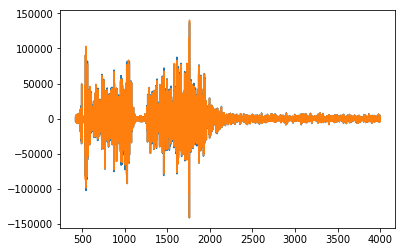

In [17]:
plt.plot(tx_train.columns, weights_baseline)
plt.plot(tx_train.columns, weights_cross)
# plt.yscale('log')
plt.show()

## Ridge regression

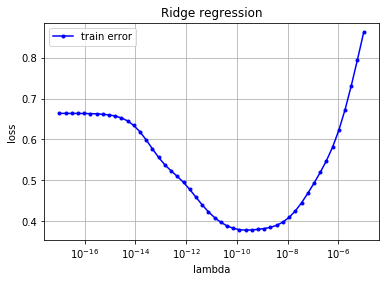

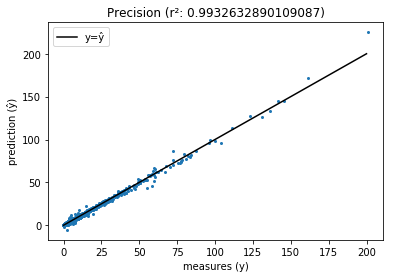

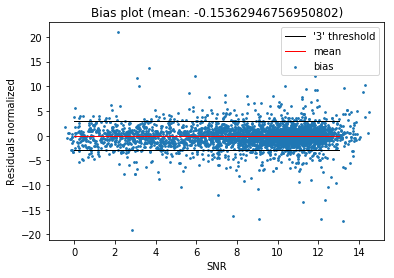

Loss is 0.37818307188147726


In [18]:
lambdas = np.logspace(-17, -5, 50)
losses = []
weights = []
for lambda_ in lambdas:
    loss, w_rr = ridge_regression(tx_train, y_train, tx_test, y_test, lambda_)
    losses.append(loss)
    weights.append(w_rr)
    
ridge_regression_lambdas_visualization(lambdas, losses, "loss_with_lambdas_ridge_regression.png")
best_lambda, best_w = lambdas[np.argmin(losses)], weights[np.argmin(losses)]
save_results(OUTPUT_FILE, "ridge regression with best lambda",  best_w, np.min(losses))
y_compare(tx_test, y_test, best_w, "rr_y-compare_simple.png")
snr_plot(tx_test, y_test, best_w, unc_test, "rr_snr_simple.png")
print("Loss is {}".format(np.min(losses)))

# Now with augmentation of the data

## Expand all features with higher degrees

In [19]:
power = 7
tx_train_expanded = build_poly(tx_train, power)
tx_test_expanded = build_poly(tx_test, power)

In [20]:
# %xdel tx_train
# %xdel tx_test
%xdel ind_tr
%xdel ind_te


## Least squares augmented

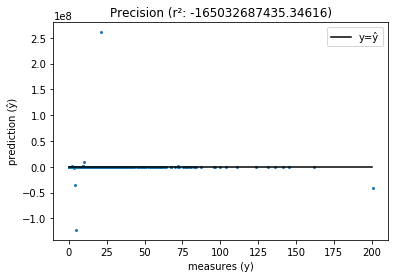

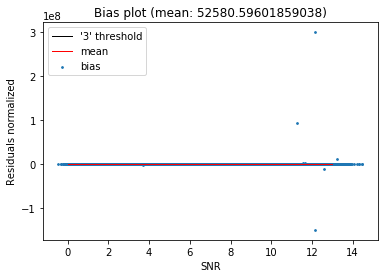

Loss is 9264545977495.092


In [21]:
loss_ls_hd, weights_ls_hd = least_squares(tx_train_expanded, y_train, tx_test_expanded, y_test)
save_results(OUTPUT_FILE, "least squares with features expansion", weights_ls_hd, loss)
y_compare(tx_test_expanded, y_test, weights_ls_hd, "ls_y-compare_higher-degrees-{}.png".format(power))
snr_plot(tx_test_expanded, y_test, weights_ls_hd, unc_test, "ls_snr_higher-degrees-{}.png".format(power))
print("Loss is {}".format(loss_ls_hd))

## Least squares cross validation augmented

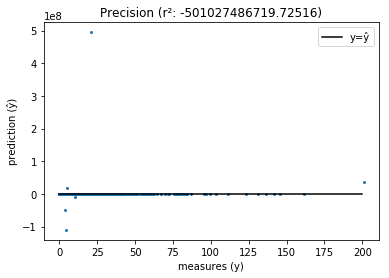

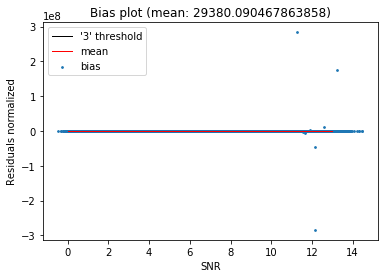

Loss is 462205660704085.9


In [23]:
kf = KFold(n_splits=10, shuffle=True)
losses, ws = [],[]
for ind_tr, ind_te in kf.split(tx_train):
    loss, w = least_squares(tx_train_expanded.iloc[ind_tr].values, 
                            y_train.iloc[ind_tr].values,
                            tx_train_expanded.iloc[ind_te].values,
                            y_train.iloc[ind_te].values)
    losses.append(loss)
    ws.append(w)

weights_cross = np.mean(np.array(ws), axis=0)
loss_cross = np.mean(losses)
y_compare(tx_test_expanded, y_test, weights_cross, "ls-cv_y-compare_higher-degrees-{}.png".format(power))
snr_plot(tx_test_expanded, y_test, weights_cross, unc_test, "ls-cv_snr_higher-degrees-{}.png".format(power))
save_results(OUTPUT_FILE, "ls-cv higher-degrees-{}".format(power), weights_cross, loss_cross)
print("Loss is {}".format(loss_cross))

## Ridge regression augmented

48.552058826022915
34.91154348373083
23.813175256696027
15.324453000176266
9.294896173209029
5.3367381043892115
2.9313973039441175
1.5852862529036462
0.9213802967914623
0.6734082810444766
0.6391033967133727
0.6669112337395977
0.6908667640122708
0.7580518778935832
0.994128461652948
1.5150335853718706
2.3415610284448043
3.3719670310300485
4.427690047241597
5.33657661967922


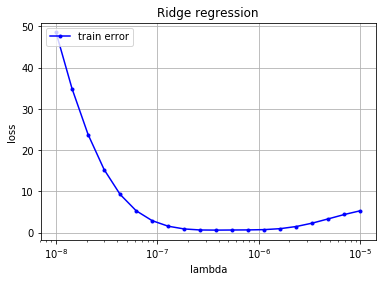

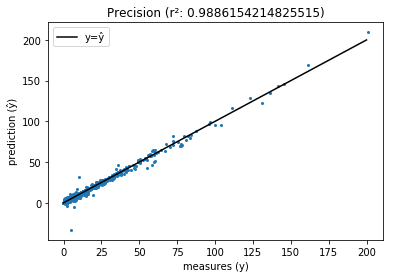

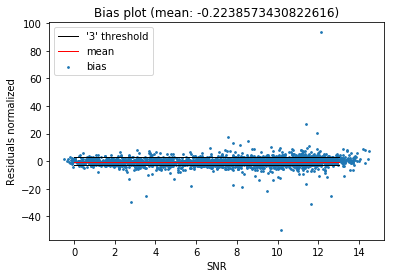

Loss is 0.6391033967133727


In [24]:
lambdas = np.logspace(-8, -5, 20)
losses = []
weights = []
for lambda_ in lambdas:
    loss, w_rr = ridge_regression(tx_train_expanded, y_train, tx_test_expanded, y_test, lambda_)
    losses.append(loss)
    weights.append(w_rr)
    print(loss)
    
ridge_regression_lambdas_visualization(lambdas, losses, "loss_with_lambdas_ridge_regression_complex_higher_degree.png")
best_lambda, best_w = lambdas[np.argmin(losses)], weights[np.argmin(losses)]
save_results(OUTPUT_FILE, "ridge regression with best lambda higher degrees",  best_w, np.min(losses))
y_compare(tx_test_expanded, y_test, best_w, "rr_y-compare_higher-degrees-{}.png".format(power))
snr_plot(tx_test_expanded, y_test, best_w, unc_test, "rr_snr_higher-degrees-{}.png".format(power))
print("Loss is {}".format(np.min(losses)))

## Expand 30 features with polynomial expansion

In [25]:
%xdel tx_train_expanded
%xdel tx_test_expanded
num_features = 30
power = 3
best_features = features_selection(tx_train, y_train, 30)
tx_train_expanded = features_expansion(tx_train, power, best_features)
tx_test_expanded = features_expansion(tx_test, power, best_features)

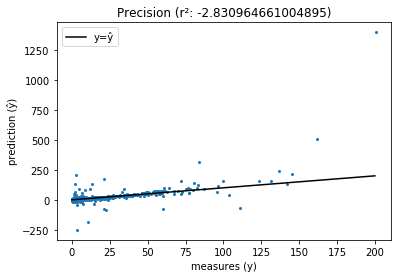

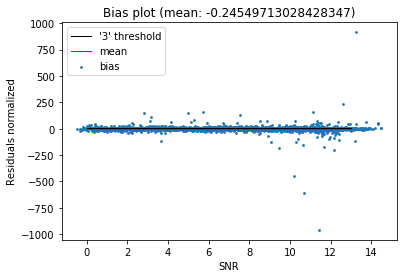

Loss is 215.0613238588175


In [26]:
loss, weights_baseline = least_squares(tx_train_expanded, y_train, tx_test_expanded, y_test)
save_results(OUTPUT_FILE, "least squares with features expansion", weights_baseline, loss)
y_compare(tx_test_expanded, y_test, weights_baseline, "ls_y-compare_complex-{}-{}.png".format(num_features, power))
snr_plot(tx_test_expanded, y_test, weights_baseline, unc_test, "ls_snr_complex-{}-{}.png".format(num_features, power))
print("Loss is {}".format(loss))

1.877726011911427
1.416645069378108
0.8330199947702818
0.5453466921848038
0.49265262687010947
0.45159114235864456
0.38666896088758596
0.33255092696274985
0.3634190181898384
0.49098596294886504
0.5637045387855456
0.5352882499206565
0.4952798254792088
0.48885271453220286
0.5363563528172064
0.6723862190668684
0.8465027739019657
1.0441934247435278
1.3460911515788767
2.0088131843951973


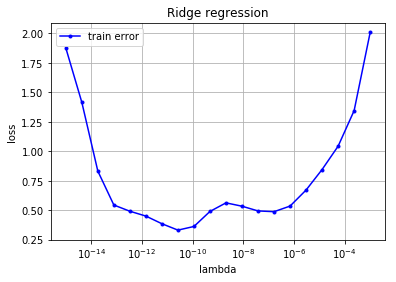

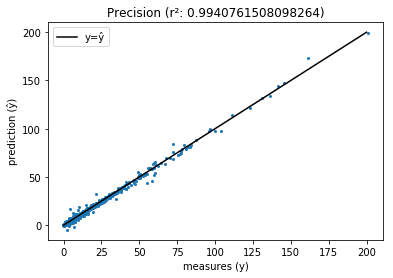

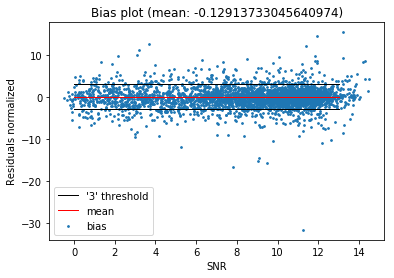

Loss is 0.33255092696274985


In [27]:
lambdas = np.logspace(-15, -3, 20)
losses = []
weights = []
for lambda_ in lambdas:
    loss, w_rr = ridge_regression(tx_train_expanded, y_train, tx_test_expanded, y_test, lambda_)
    losses.append(loss)
    weights.append(w_rr)
    print(loss)
    
ridge_regression_lambdas_visualization(lambdas, losses, "loss_with_lambdas_ridge_regression_complex.png")
best_lambda, best_w = lambdas[np.argmin(losses)], weights[np.argmin(losses)]
save_results(OUTPUT_FILE, "ridge regression with best lambda complex",  best_w, np.min(losses))
y_compare(tx_test_expanded, y_test, best_w, "rr_y-compare_complex-{}-{}.png".format(num_features, power))
snr_plot(tx_test_expanded, y_test, best_w, unc_test, "rr_snr_complex-{}-{}.png".format(num_features, power))
print("Loss is {}".format(np.min(losses)))